In [201]:
import scanpy as sc
import numpy as np
import sctm
import squidpy as sq
import pandas as pd
import scvi

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this tutorial, we demonstrate how to analyse single cell level nanostring smi data. We used replicate 12 to demonstrate here instead of 5-3 in our paper. We transferred our data from the Giotto object located here https://nanostring.com/products/cosmx-spatial-molecular-imager/nsclc-ffpe-dataset

In [157]:
adata = sc.read_h5ad("../../../../spatialLDA/spatiallda/reproducibility/figure2/data/Lung12.h5ad")
adata.var_names_make_unique()

In [158]:
adata.obsm['spatial'] = adata.obsm['spatial_raw']

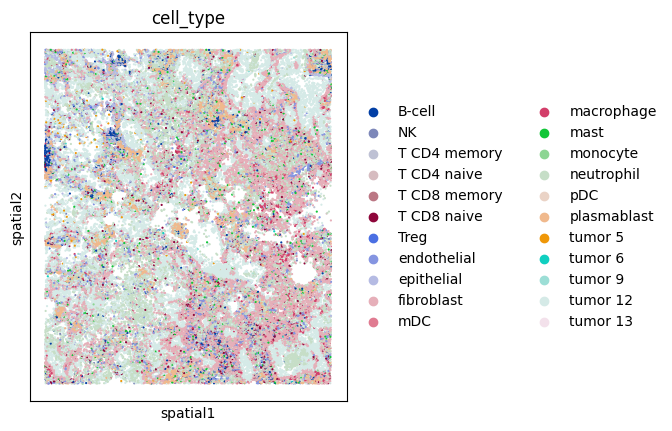

In [159]:
sc.pl.spatial(adata, spot_size = 0.03, color = 'cell_type')

In [160]:
sc.pp.filter_cells(adata, min_genes=30)
sctm.pp.filter_genes(adata, 0.01,  expression_cutoff_99q = 0)
sc.pp.highly_variable_genes(adata, n_top_genes=600, flavor="seurat_v3")

In [161]:
sq.gr.spatial_neighbors(adata)

In [164]:
n_topics = 15
# 
model = sctm.stamp.STAMP(
    adata[:, adata.var.highly_variable],
    n_topics = n_topics,
)

# uses gpu by default to use cpu use device="cpu"
model.train(learning_rate = 0.01)

Computing background frequencies
Layer (type:depth-idx)                   Param #
spatialLDAModel                          --
├─MLPEncoderMVN: 1-1                     --
│    └─Dropout: 2-1                      --
│    └─BatchNorm1d: 2-2                  2,400
│    └─BatchNorm1d: 2-3                  100
│    └─BatchNorm1d: 2-4                  --
│    └─Linear: 2-5                       765
│    └─Linear: 2-6                       765
│    └─Linear: 2-7                       5,355
│    └─Linear: 2-8                       60,050
Total params: 69,435
Trainable params: 69,435
Non-trainable params: 0


Loss:252.536:   9%|██████████▎                                                                                                           | 175/2000 [16:12<2:49:01,  5.56s/it]

Early Stopping


In [165]:
# Get topic prop which is the latent representation and beta which are the gene modules
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
# Add it into adata to visualize
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

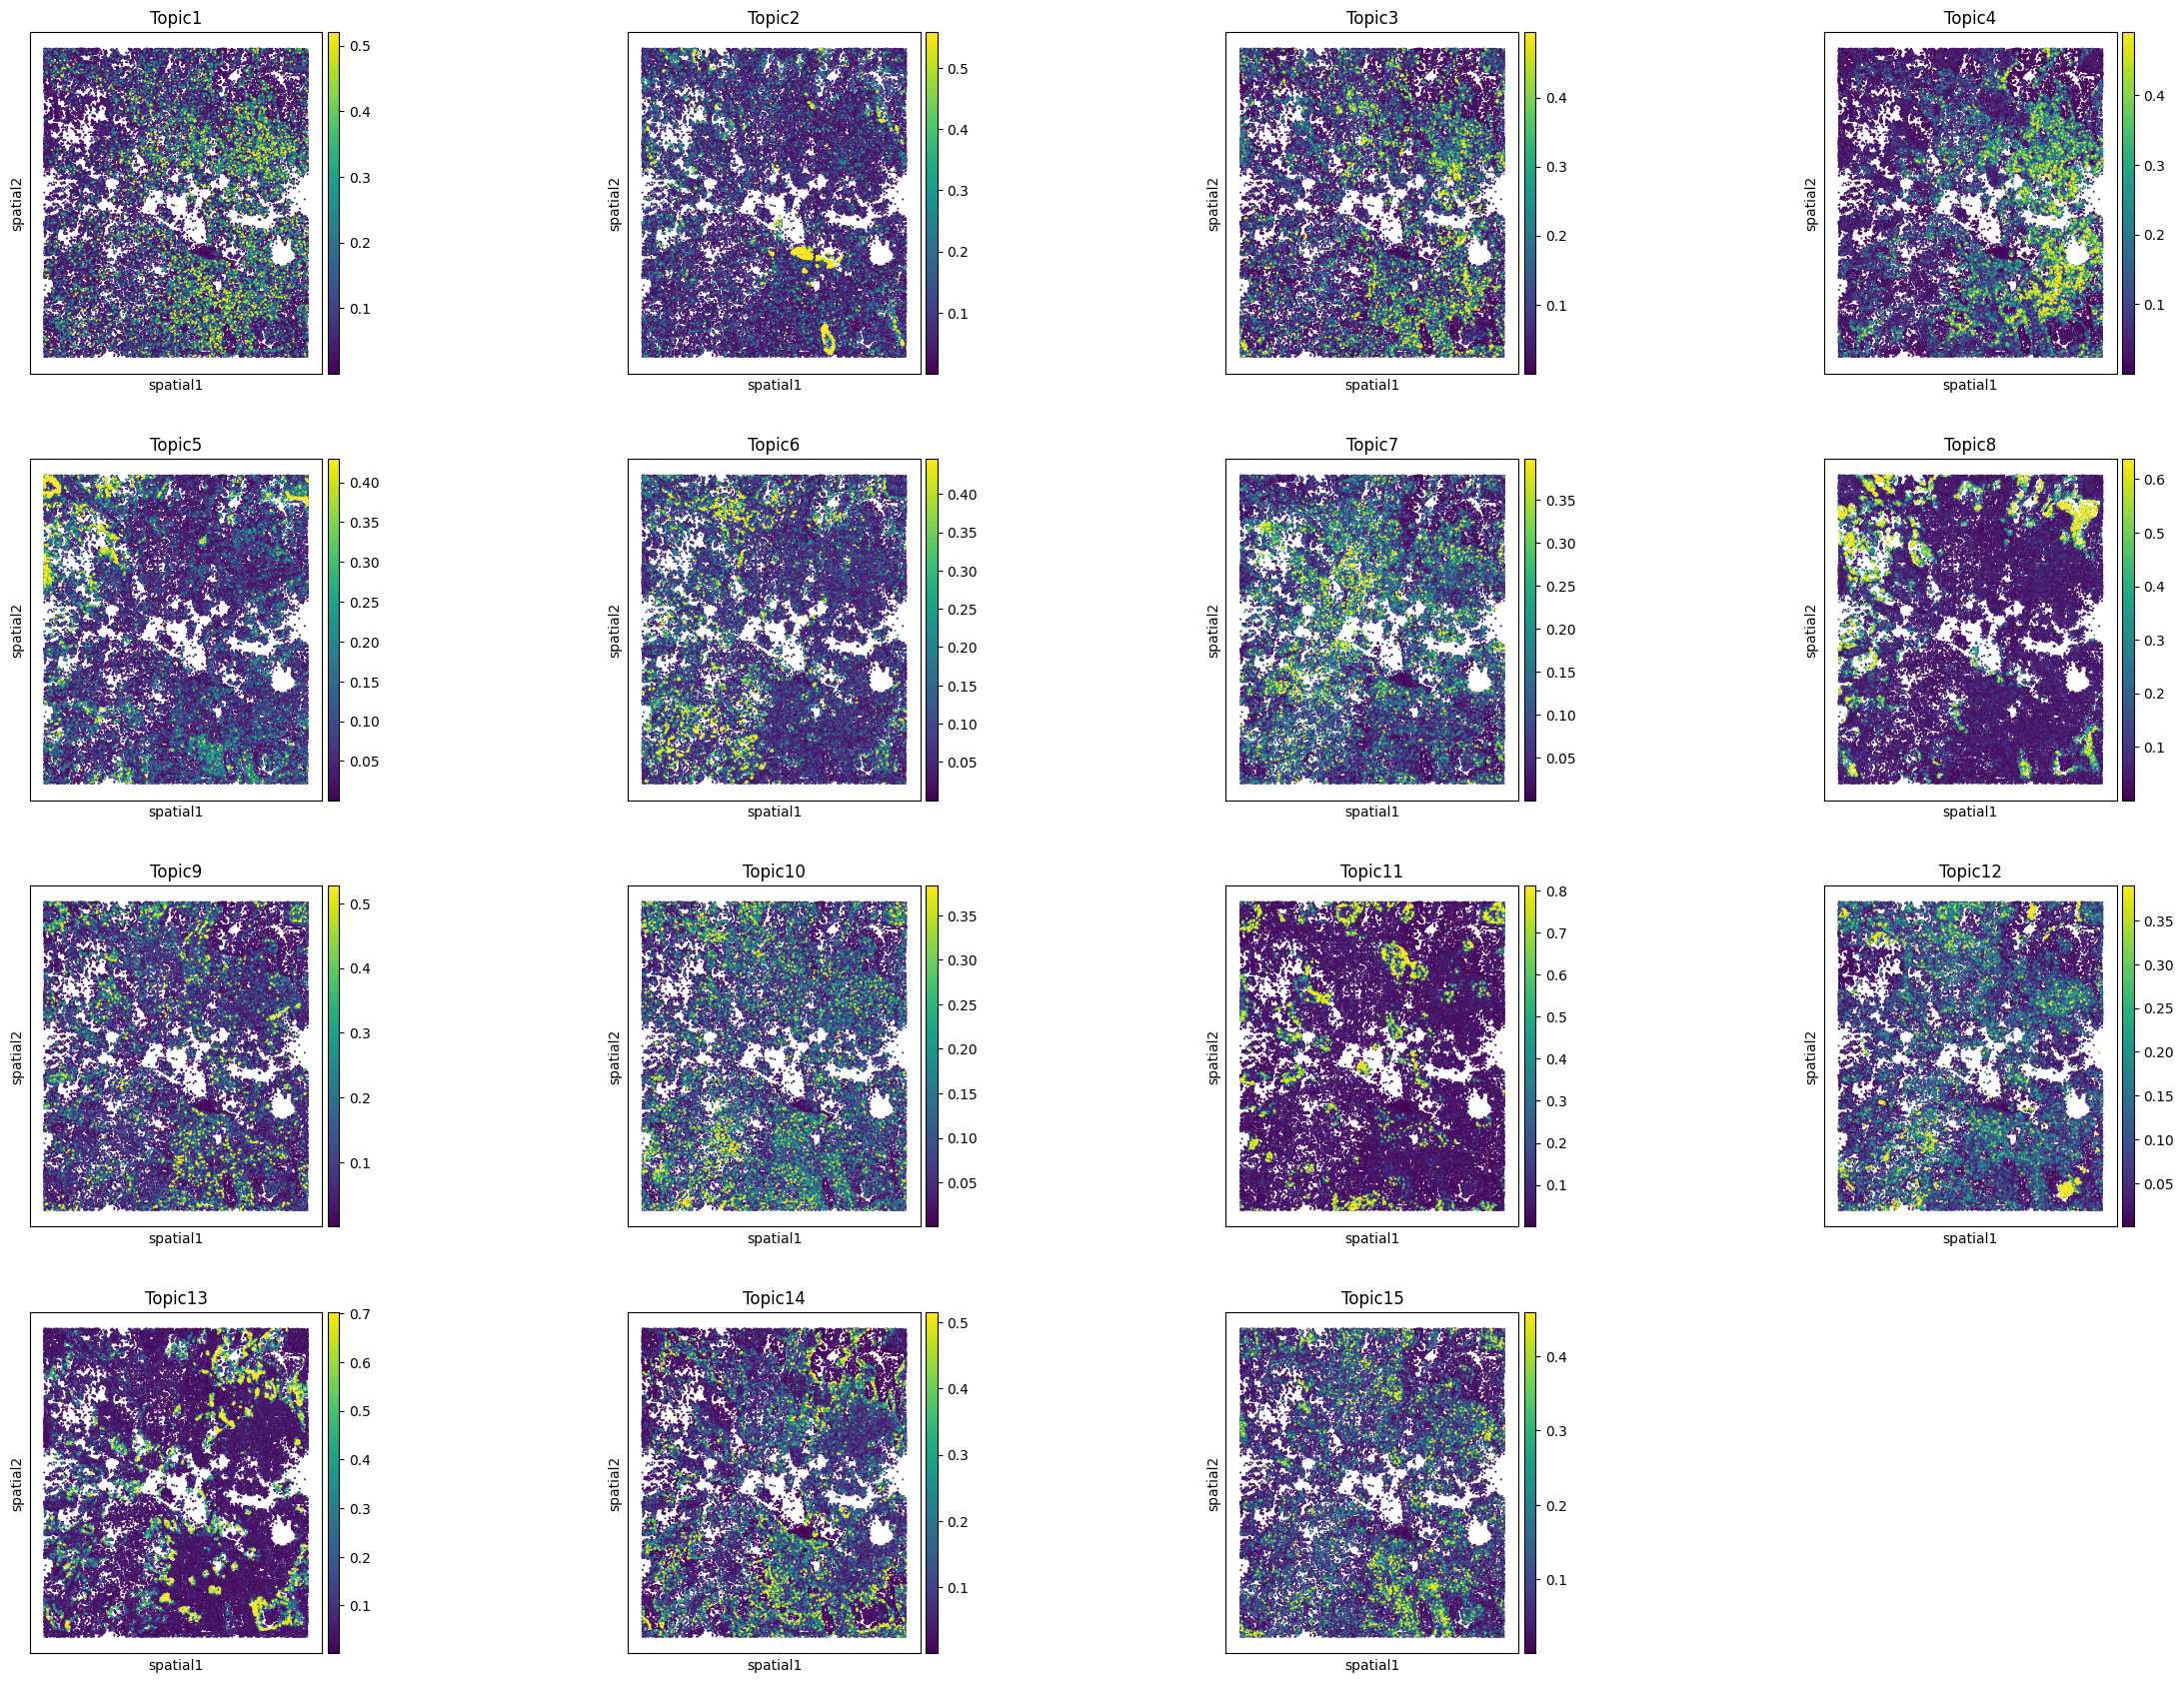

In [170]:
sc.pl.spatial(adata, color = topic_prop.columns, spot_size = 0.03, vmax = 'p99')

Here we used the disco function which calls discotoolkit_py to do enrichment analysis.

The website for DISCO can be found here https://immunesinglecell.org/, where over 60 million cells are processed and built into atlases.

In [184]:
celltypes = sctm.analysis.get_topic_disco(beta)

INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:root:Comparing the ranked gene list to reference gene sets...
[Parallel(n_jobs=1)]: Using backend Sequentia

In [209]:
filtered = [] 
for i in celltypes.keys():
    # Filter out the low overlap
    df = celltypes[i].loc[celltypes[i].overlap > 5]
    df["Topic"] = i
    filtered.append(df.head(2))

In [210]:
filtered = pd.concat(filtered)
filtered

pval       or                                               name   
279   0.0   38.945  CCL19+APOE+ fibroblast vs All others in intestine  \
437   0.0   37.792      GPC3+ fibroblast vs Myofibroblast in placenta   
159   0.0  145.714             Paneth cell vs All others in intestine   
190   0.0   48.705           Goblet cell vs Airway basal cell in lung   
740   0.0  385.666                   Macrophage vs All others in skin   
656   0.0  329.269                   Macrophage vs All others in PDAC   
312   0.0  187.507            Myofibroblast vs All others in pancreas   
601   0.0  120.071  Sertoli and Interstitial cell common progenito...   
411   0.0   58.518                   Club cell vs Cycling AT2 in lung   
403   0.0   56.080           Goblet cell vs Airway basal cell in lung   
64    0.0   53.140  Secretoglobin mammary luminal progenitor vs Al...   
204   0.0   46.662  CLDN3+ epithelial cell vs AFP+ epithelial cell...   
535   0.0   81.064    PDAC specific ductal cell vs All others in PDAC   
383   0.0   63.425          TFF+ cholangiocyte vs All others in liver   
69    0.0   97.880            Endothelial cell vs All others in brain   
144   0.0   55.982  CCL19+APOE+ fibroblast vs CD9+APCDD1+ fibrobla...   
281   0.0  106.879                Mast cell vs Macrophage in pancreas   
85    0.0   68.767                  Mast cell vs All others in breast   
36    0.0  163.186               Plasma cell vs All others in bladder   
8     0.0  135.393               Plasma cell vs All others in adipose   
308   0.0   64.473                Granulocyte vs All others in tonsil   
293   0.0   37.415                   Monocyte vs All others in testis   
222   0.0   47.771  APOD+PTGDS+ fibroblast vs CXCL5+ADAM12+ fibrob...   
491   0.0   42.436        MT2A+ ductal cell vs All others in pancreas   
474   0.0  174.922            Myofibroblast vs All others in placenta   
42    0.0  139.819          Fibroblast vs All others in adrenal_gland   
175   0.0  182.576                      T cell vs All others in brain   
408   0.0  127.412         GZMK CD8 T cell vs All others in intestine   

                                                  gene background overlap   
279  VCAM1,CXCL12,COL6A1,COL6A2,PDGFRA,BMP7,CDH11,M...      11184      11  \
437         MEG3,CDH11,COL6A2,COL6A1,BMP4,VCAM1,PDGFRA       8302       7   
159  LYZ,SERPINA1,LCN2,OLFM4,PIGR,SOX9,EPCAM,AGR2,L...      11184       9   
190               PIGR,LCN2,MGP,LYZ,SERPINA1,MMP7,AGR2       9264       7   
740  C1QA,C1QC,C1QB,MARCO,CD14,CD74,HLA-DRA,HLA-DRB...       8928      20   
656  C1QA,C1QC,C1QB,CD14,CD74,HLA-DRA,HLA-DRB1,HLA-...       9711      20   
312  COL11A1,COL3A1,FN1,COL6A3,COL8A1,PDGFRA,CXCL14...       5783      17   
601  COL1A1,COL3A1,COL1A2,CDH11,PDGFRA,COL6A2,COL6A...      13055      16   
411                  CLU,SCGB3A1,CXCL17,MALAT1,MGP,LTF       9264       6   
403   PIGR,SCGB3A1,SLPI,MGP,CXCL17,CLU,LTF,CXCL2,CXCL3       9264       9   
64   TACSTD2,ITGB8,CLDN4,KRT7,KRT19,ITGB6,CDH1,KRT1...       8742      10   
204  KRT19,CLDN4,KRT7,SLC2A1,TACSTD2,CDH1,ITGA3,KRT...      11275      10   
535  S100A6,PIGR,S100P,AGR2,CLDN4,KRT7,KRT8,LGALS3,...       9711      17   
383  PIGR,AGR2,CEACAM6,KRT19,CLDN4,KRT8,KRT7,ANXA4,...       9455      15   
69   RGS5,KDR,TIMP1,ESAM,VWF,MGP,PGF,CDH5,RAMP2,PEC...       7173      18   
144   MGP,SPARCL1,IGFBP3,COL4A2,COL4A1,PGF,CCL21,TIMP1       5938       8   
281               CPA3,TPSAB1,KIT,TPSB2,IL1RL1,LIF,CLU       5783       7   
85          CPA3,TPSB2,TPSAB1,IL1RL1,KIT,IL18R1,ADGRE2       8742       7   
36   IGKC,CD38,JCHAIN,MZB1,IGHG2,IGHG1,TNFRSF17,CD7...       6448      11   
8    IGKC,JCHAIN,MZB1,IGHG2,IGHA1,IGHG1,IGHM,TNFRSF...       8484      11   
308  CXCR1,CXCL8,CXCL1,HCAR2,IL1RN,IL1B,IL1R2,CCL3,...       7683      10   
293         CD33,IL1B,BST1,IL1RN,HCAR2,CD36,CCL3,CXCL8      13055       8   
222         KRT17,S100A6,S100A2,TACSTD2,SLC2A1,S100A10       5938       6   
491  S100A2,KRT17,S100A10,KRT7,ITGA3,IT

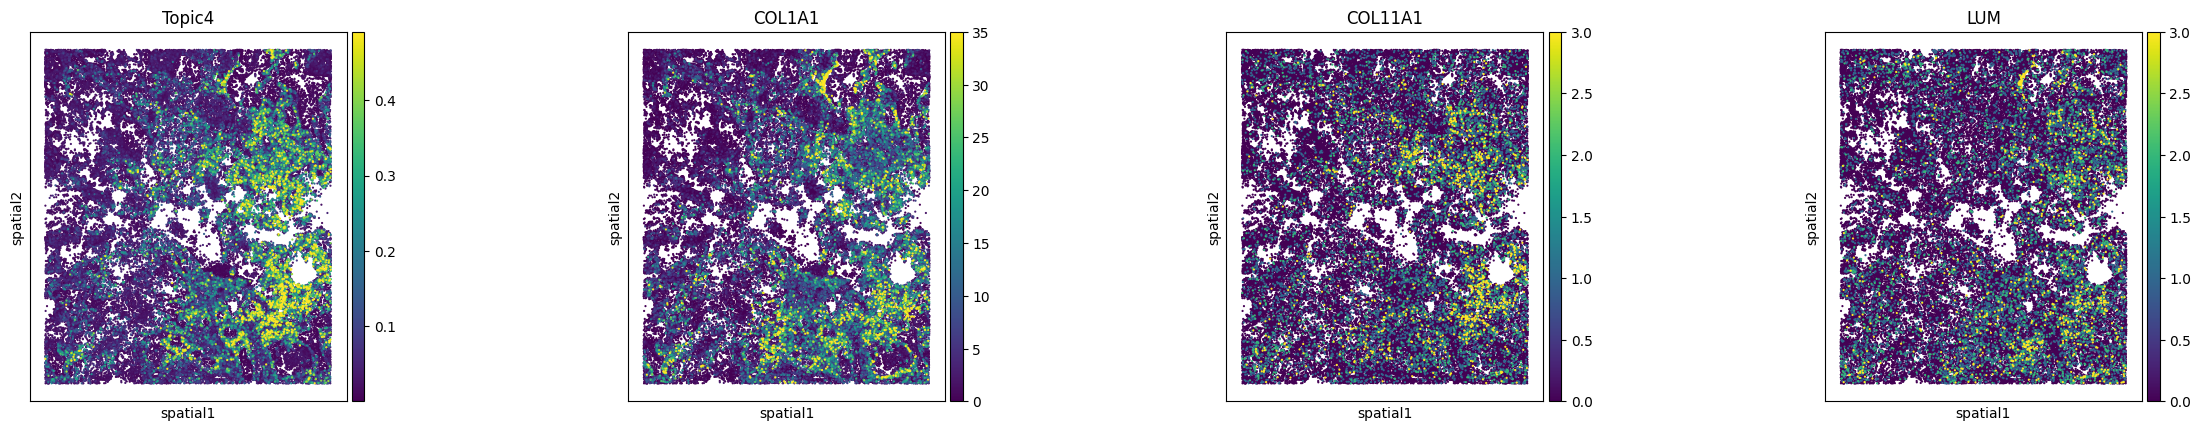

In [212]:
# Plot out myofibrolast and top genes "Topic4"
sc.pl.spatial(adata, color = ["Topic4"] + beta.nlargest(3, "Topic4").index.tolist(), spot_size = 0.03, vmax ='p99')